## Assignment 3

### Import libraries

In [222]:
import pandas as pd
import numpy as np

import nltk
import html
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer,WordNetLemmatizer
import re
import unicodedata
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from statistics import mean
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelahsu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/angelahsu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Data cleaning

1. All html tags and attributes are removed. I imported BeautifulSoup package, an HTML-parsing libraries, and used 'html.parser' as an implementation of HTML-parsing.

2. Html character codes are replaced with an ASCII equivalent. 

3. All URLs and @ are removed.

4. All characters in the text are in lowercase.

5. All stop words are removed. I imported stopwords package from nltk.corpus which contains all the stopwords.

6. If a tweet is empty after pre-processing, it should be preserved as such.

7. Lemmatization is the process of converting a word to its base form. Wordnet is an large, freely and publicly available lexical database for the English language aiming to establish structured semantic relationships between words. In order to lemmatize, you need to download Wordnet, create an instance of the WordNetLemmatizer() and call the lemmatize() function on a single word.

### (a) Clean sentiment data

In [223]:
df_sentiment = pd.read_csv('sentiment_analysis.csv')
df_sentiment

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1
...,...,...,...
550386,8.046170e+17,@goddesses_o I can't stop watching her...mm. M...,0
550387,8.046180e+17,Poor old Tom Odell doesn't look like he would ...,0
550388,8.046180e+17,#antsmasher I smashed 7 ants in this awesome ...,1
550389,8.046180e+17,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1


In [3]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
def clean_data_1(text):

    # convert 'RT @'' to '@' and Remove the word after @
    rt = re.compile('RT @')
    text = re.sub(rt, '@', str(text))
    at = re.compile('@(?=\w+)\w+')
    text = re.sub(at,'', str(text))
    
    #remove emoji
    emoji = re.compile(r'\\[x][a-z\d]{2}')
    text = re.sub(emoji,'', text)
    
    #remove html tags and attributes
    text = BeautifulSoup(text,'html.parser').get_text()

    #replace ASCII
    text = html.unescape(text)
    text = unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8')

    #remove URLs
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

    #lowercase
    text = text.lower()

    #remove stop words 
    text = [word for word in tokenizer.tokenize(text) if word not in stopwords.words('english')]
    
    #lemmatize words
    text = [lemmatizer.lemmatize(word, pos='v') for word in text]
    text = [lemmatizer.lemmatize(word, pos='n') for word in text]
    return text

In [4]:
%%time
df_sentiment['text']=list(map(clean_data_1,df_sentiment['text']))

CPU times: user 13min 1s, sys: 3min 18s, total: 16min 20s
Wall time: 17min 33s


In [5]:
df_sentiment

,ID,text,label
0,7.680980e+17,"[josh, jenkins, look, forward, tab, breeder, c...",1
1,7.680980e+17,"[congratulation, pakistan, become, no1testteam...",1
2,7.680980e+17,"[september, take, maine, mendozas, surprise, t...",1
3,7.680980e+17,"[newly, paint, wall, thank, million, custodial...",1
4,7.680980e+17,"[excite, announce, july, 2017, feschotte, lab,...",1
...,...,...,...
550386,8.046170e+17,"[stop, watch, mm]",0
550387,8.046180e+17,"[poor, old, tom, odell, look, like, would, kno...",0
550388,8.046180e+17,"[antsmasher, smash, 7, ant, awesome, game, hjf...",1
550389,8.046180e+17,"[morning, girl, wonderful, friday]",1


### (b) Clean elections data

For Canadian election data, I added one more cleaning which is to remove b'/b" at the beginning of the tweets and the \n in the tweets.

In [6]:
df_election = pd.read_csv('Canadian_elections_2019.csv')
df_election

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."
...,...,...,...
2128,negative,Scandal,b'You know he was doing a good enough job smea...
2129,negative,Scandal,b'You missed the comment. Deflecting the issue...
2130,positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...
2131,negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...


In [9]:
def clean_data_2(text):
    
    #remove unknown characters b and \\n
    text = text.replace('\\n','')
    text = re.sub(r'[b]\"|[b]\'', '', text)
    
    #remove emoji
    emoji = re.compile(r'\\[x][a-z\d]{2}')
    text = re.sub(emoji,'', text)
    
    # Remove the word after @
    text = re.compile('RT @').sub('@', str(text))
    at = re.compile('@(?=\w+)\w+')
    text = re.sub(at,'', str(text))
    
    #remove html tags and attributes
    text = BeautifulSoup(text,'html.parser').get_text()

    #replace ASCII
    text = html.unescape(text)
    text = unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8')

    #remove URLs
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

    #lowercase
    text = text.lower()

    #remove stop words 
    text = [word for word in tokenizer.tokenize(text) if word not in stopwords.words('english')]
    
    #lemmatize words
    text = [lemmatizer.lemmatize(word, pos='v') for word in text]
    text = [lemmatizer.lemmatize(word, pos='n') for word in text]
    
    return text

In [10]:
df_election['text']=list(map(clean_data_2,df_election['text']))

In [11]:
df_election

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"[instead, suggestion, agree, canadian, woman, ..."
1,positive,NaN,"[allwomanspacewalk, real, etobicokenorth, city..."
2,negative,Economy,"[brantford, go, cost, 94, billion, next, 4, ye..."
3,positive,NaN,"[canada, canadaelection2019, canadavotes, elxn..."
4,negative,Economy,"[canada, taxpayer, sick, tire, hard, earn, don..."
...,...,...,...
2128,negative,Scandal,"[know, good, enough, job, smear, campaign, rig..."
2129,negative,Scandal,"[miss, comment, deflect, issue, answer, best, ..."
2130,positive,NaN,"[daily, reminder, endorse, strategic, vote, el..."
2131,negative,Women Reproductive right and Racism,"[yup, go, reopen, abortion, debate, elxn43, sc..."


## 2. Exploratory data analysis

There are three political parties in consideration which are Liberal, Conservative and NDP. To determine the political affiliation, chech whether the tweet contains any of these identifiers related to certain political parties or candidates. The identifiers are listed as below.

### (a) Create keywords lists for political parties
For each political party, there is a list that contain the relevant keywords which can reflect political preference. The keywords are determined by leader, slogan, hashtag. 

Relevant Information for Different Politocal Parties:
1. **Liberal**
    - Leader: Justin Trudeau
    - Twitter Account: @JustinTrudeau
    - Slogan: 'chooseforward'
    - Hashtag: #lpc
    - Identifiers:    "Justin Trudeau" ;
                      "Trudeau";
                      "Justin"
                      "Choose forward";
                      "Proven leadership for a strong Canada";
                      "Safer Canada/Stronger Economy";
                      "Protect our Economy";
                      "liberal";
                      "#LavScam";
                      "Trudeau must go";
                      "#TrudeauMustGo";
                      "#LiberalsMustGo"
                      "#TrudeauBlackface";
                      "#NotAsAdvertised";
                      "#LiberalLiesAndDeception";
    
2. **Conservative**
    - Leader: Andrew Scheer
    - Twitter Account: @AndrewScheer
    - Slogan: 'it's time for your to get ahead'
    - Hashtag: #cpc
    - Identifiers: "Andrew Scheer"; 
                    "Andrew";
                    "Scheer";
                    "#Scheer4PM";
                    "#ScheerMajority";
                    "It's time for you to get ahead";
                    "conservative";
                    "Real Change (Now)";
                    "#ScheerLies";
                    "#ScheerStupidity";
                    "#ScheerDelusion";
                    "#Scheer2019"

3. **New Democratic**
    - Leader: Jagmeet Singh
    - Twitter Account: @theJagmeetSingh
    - Slogan: 'in it for you'
    - Hashtag: #ndp
    - Identifiers: "Jagmeet Singh" ; 
                    "Jagmeet";
                    "Singh";
                    "In it for you" ; 
                    "We fight for you" ;
                    "Ready for Change";
                    "#SinghUpSwing";
                    "#Jaggernaut";
                    "#UpRiSingh"

4. **None**
    - Includes Bloc Quebecois and Green parties

### (b) Return only one party or return none
Since there may be cases that multiple parties are mentioned, I need to compare which party is mentioned most frequently and return only one political party. Also, there may be cases where tweet exhibits no political affiliation and thus return None to show no political interest.

In [12]:
def party(text):
    
    #define the words that show political inclination
    l_ls = ['trudeau', "justin", "justintrudeau", 
               "liberal","liberals","red",
               "safercanada","strongereconomy","protectoureconomy",
               "teamtrudeau","lpc",'voteliberal','chooseforward']
    
    c_ls = ['andrew scheer','conservatives', 'cpc','andrew',
            'scheer','scheer2019','scheerMajority','scheer4PM',
            'andrewscheer','conservative','voteconservative','getahead',
            'it is time for you to get ahead']
    
    n_ls = ['new democratic party','ndp','ptndp','thejagmeet',
            'jagmeet','singh','jagmeetsingh','democratic','democrats',
            'initforyou','singhupswing','uprisingh','we fight for you','jaggernaut','ready for change']
    
    mention = []

    #identify the political party based on lists of keywords
    for word in text:
        if word in l_ls:
              mention.append('liberal')
        if word in c_ls:
              mention.append('conservatives')
        if word in n_ls:
              mention.append('new democratic party')
                
    # If there are multiple parties mentioned, return the party mentioned most frequently
    if len(mention) > 1:
        most_frequent = max(set(mention), key=mention.count)
        mention = []
        mention.append(most_frequent)
        
    # If there is no party mentioned in the list, return None 
    elif len(mention) == 0:
        mention.append('None')
    
    #return value rather than list
    return mention[0] 

In [13]:
# add a column to df_election to show political affiliation
df_election['political_party'] = ''
df_election

,sentiment,negative_reason,text,political_party
0,negative,Women Reproductive right and Racism,"[instead, suggestion, agree, canadian, woman, ...",
1,positive,NaN,"[allwomanspacewalk, real, etobicokenorth, city...",
2,negative,Economy,"[brantford, go, cost, 94, billion, next, 4, ye...",
3,positive,NaN,"[canada, canadaelection2019, canadavotes, elxn...",
4,negative,Economy,"[canada, taxpayer, sick, tire, hard, earn, don...",
...,...,...,...,...
2128,negative,Scandal,"[know, good, enough, job, smear, campaign, rig...",
2129,negative,Scandal,"[miss, comment, deflect, issue, answer, best, ...",
2130,positive,NaN,"[daily, reminder, endorse, strategic, vote, el...",
2131,negative,Women Reproductive right and Racism,"[yup, go, reopen, abortion, debate, elxn43, sc...",


In [16]:
#call the function to determine party affiliation
df_election['political_party']=list(map(party,df_election['text']))
df_election

,sentiment,negative_reason,text,political_party
0,negative,Women Reproductive right and Racism,"[instead, suggestion, agree, canadian, woman, ...",conservatives
1,positive,NaN,"[allwomanspacewalk, real, etobicokenorth, city...",None
2,negative,Economy,"[brantford, go, cost, 94, billion, next, 4, ye...",liberal
3,positive,NaN,"[canada, canadaelection2019, canadavotes, elxn...",None
4,negative,Economy,"[canada, taxpayer, sick, tire, hard, earn, don...",None
...,...,...,...,...
2128,negative,Scandal,"[know, good, enough, job, smear, campaign, rig...",None
2129,negative,Scandal,"[miss, comment, deflect, issue, answer, best, ...",None
2130,positive,NaN,"[daily, reminder, endorse, strategic, vote, el...",liberal
2131,negative,Women Reproductive right and Racism,"[yup, go, reopen, abortion, debate, elxn43, sc...",None


### (c) Present graphical figures for political parties
By presenting the political parties in histogram, I surprisingly found that the dominating political party is "None". It may be that the keywords are not enough to classify political parties or people are more interested in other parties. Other than "None", liberal party and conservative party are two main portion in tweets, while NDP occupy only a little portion.

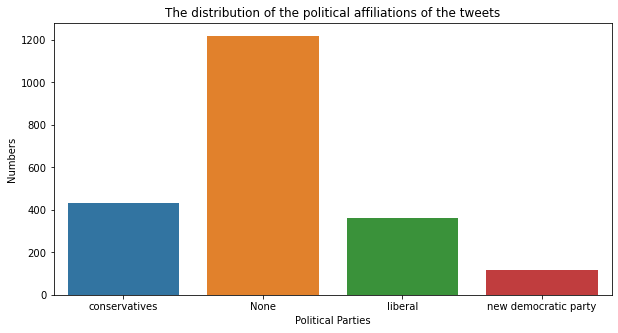

In [206]:
# Histogram of political parties
plt.figure(figsize=(10,5))
ax = sns.countplot(x='political_party',data=df_election)
ax.axes.set_title('The distribution of the political affiliations of the tweets')
ax.set_xlabel('Political Parties')
ax.set_ylabel('Numbers')
plt.show()

### (d) Present graphical figures for sentiment
By presenting the sentiment in histogram, I found that positive sentiment is about double more than the negative sentiment.

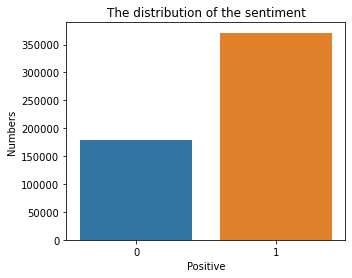

In [208]:
# Plot distribution of tweets with sentiment values for each party
plt.figure(figsize=(5,4))
ax = sns.countplot(x='label', data=df_sentiment)
ax.axes.set_title('The distribution of the sentiment')
ax.set_xlabel('Positive')
ax.set_ylabel('Numbers')
plt.show()

### (e) Present distribution of negative reason for election 
To visualize some other aspects for election, I draw a piechart to show the distribution of negative reasons. From the piechart shown, it is obvious that "scandal", "tell lies" and "others" are three dominating categories in ten negative reasons. On the contrary, "healthcare" and "marijuana" are two least important factors. Therefore, people care more about leader's characteristics. 

In [19]:
# There are ten negative resons
df_election['negative_reason'].unique()

array(['Women Reproductive right and Racism', nan, 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

In [20]:
# Obtain negative reasons
neg_reasons = df_election['negative_reason'].tolist()
# Remove Nans
neg_reasons = [x for x in neg_reasons if str(x) != 'nan']
neg_count = Counter(neg_reasons)

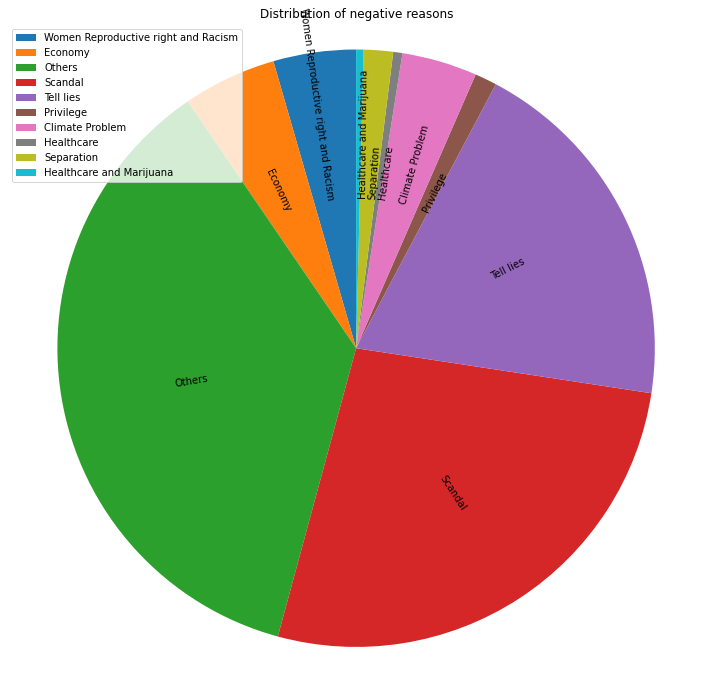

In [25]:
# draw the pie chart
fig, ax = plt.subplots(figsize=[10, 10])
ax.pie(neg_count.values(), labels=neg_count.keys(), rotatelabels=True,labeldistance=0.5, pctdistance=0.6, startangle=90)
ax.axis('equal')  
ax.set_title('Distribution of negative reasons')
plt.legend(loc="upper left")
fig.tight_layout()
plt.show()

### Bonus: Wordcloud on Positive Sentiment for Liberal Party
I used word cloud to show the most frequent words that appear in positive sentiments on liberal party, which is the winner party in 2019 election. As shown in the wordcloud, the most popular word is "chooseforward", "liberal", and "trudeau". However, "elxn43" and "cdnpoli" are not appropriate and cannot provide any useful information, which should be removed during the following prediction.

In [28]:
# Transform list of string into a master string to pass into wordcloud
lib = df_election[df_election['political_party'] == 'liberal']
lib_positive = lib[lib['sentiment'] == 'positive']

lib_positive['text']=lib_positive['text'].map(lambda x: ' '.join(map(str, x)))
lib_positive['text']=lib_positive['text'].map(lambda x: x+' ')
positive_lib=lib_positive['text'].sum()

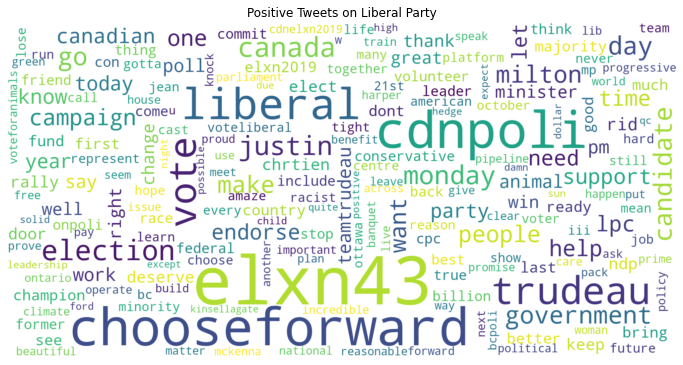

In [29]:
# Generate the wordcloud 
wordcloud = WordCloud(width=2000, height=1000, max_font_size=200, collocations=False, background_color='white').generate(positive_lib)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Positive Tweets on Liberal Party')
plt.show()

## 3. Model Preparation

Since machine learning can only deal with numbers, thus we need to convert our text into numbers. To prepare the data for text classification problem, I vectorize the data so that text data is transformed into numerical one. Different approaches exist to convert text into the corresponding numerical form. The Bag of Words Model and the TF-IDF are two of the most commonly used approaches.

### Bag of words

I used CountVectorizer class from the sklearn.feature_extraction.text library. It converts a collection of text documents to a matrix of token counts. I set max_features parameter to 1000, which means I want 1000 most occurring words as features for training classifier. I also set max_df parameter to 0.8, which mean that we should include only those words that occur in a maximum of 80% of all the documents. Words that occur in almost every document are usually not suitable for classification because they do not provide any unique information about the document. Then, the fit_transform function of the CountVectorizer class converts text documents into corresponding numeric features.

In [30]:
df=df_sentiment.copy()
# Convert list of words to string 
df['text'] = df['text'].map(lambda x: ' '.join(map(str, x)))
df

,ID,text,label
0,7.680980e+17,josh jenkins look forward tab breeder crown su...,1
1,7.680980e+17,congratulation pakistan become no1testteam wor...,1
2,7.680980e+17,september take maine mendozas surprise thanksg...,1
3,7.680980e+17,newly paint wall thank million custodial paint...,1
4,7.680980e+17,excite announce july 2017 feschotte lab reloca...,1
...,...,...,...
550386,8.046170e+17,stop watch mm,0
550387,8.046180e+17,poor old tom odell look like would know wrong ...,0
550388,8.046180e+17,antsmasher smash 7 ant awesome game hjfjfi,1
550389,8.046180e+17,morning girl wonderful friday,1


In [31]:
# Transform generic tweets and set max_features to be 1000
vec_wf = CountVectorizer(max_features=1000, max_df = 0.8)
array_wf = vec_wf.fit_transform(df['text'])

In [32]:
# Split generic tweets randomly into train data and test data
Xwf_train, Xwf_test, ywf_train, ywf_test = train_test_split(array_wf, df['label'],test_size=0.3,stratify=df['label'])

### TF-IDF

The TF stands for "Term Frequency" while IDF stands for "Inverse Document Frequency". TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents. The TFIDF value for a word in a particular document is higher if the frequency of occurrence of that word is higher in that specific document but lower in all the other documents.

In [33]:
# Transform generic tweets and set max_features to be 1000
vec_tf = TfidfVectorizer(max_features=1000, max_df=0.8)
array_tf = vec_tf.fit_transform(df['text'])

In [34]:
# Split generic tweets randomly into train data and test data
Xtf_train, Xtf_test, ytf_train, ytf_test = train_test_split(array_tf, df['label'],test_size=0.3,stratify=df['label'])

# 4. Model Implementation

### (a) Choose Optimal Model by Tuning Hyper-parameters

Among seven models, logistic regression / k-NN / Naive Bayes / SVM / decision trees / Random Forest / XGBoost, I found that Logistic Regression is the best model in terms of accuracy in predictions, which is 94.29%.

In [35]:
#Best hyperparameters are recorded in this function for WF features
def get_model_accuracy_wf(model, X_test,y_test):
    
    dic = {'lr':'Logistic Regression',
          'knn':'K Nearest Neighbors',
          'nb':'Naive Bayes',
          'svm':'Support Vector Machine',
          'dt':'Decision Tree',
          'rf':'Random Forest',
          'ab':'Ada Boosting',
          'xgb': 'XGBClassifier'}
    
    train_acc, test_acc = [], []
    # predict using test data
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)   
 
    print("Model: ", dic[model])
    print("Test accuracy: {}".format(test_acc))

In [36]:
#Best hyperparameters are recorded in this function for WF features
def get_model_accuracy_tf(model, X_test,y_test):
    
    dic = {'lr':'Logistic Regression',
          'knn':'K Nearest Neighbors',
          'nb':'Naive Bayes',
          'svm':'Support Vector Machine',
          'dt':'Decision Tree',
          'rf':'Random Forest',
          'ab':'Ada Boosting',
          'xgb': 'XGBClassifier'}
    
    train_acc, test_acc = [], []
    # predict using test data
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)   
 
    print("Model: ", dic[model])
    print("Test accuracy: {}".format(test_acc))

### (1) Logistic Regression

I chose a hyper-parameters for tunning, which are C. C is the inverse of regularization term. Small value of C means large regularization which penalizes more on large weights to reduce overfitting and vice versa. 

##### Hyper-Parameter Tuning by Cross-Validation

In [171]:
%%time
parameters = {'C':[0.01, 0.1, 1, 10, 100], 'solver':('liblinear','lbfgs', 'newton-cg')}

clf_lr = LogisticRegression(max_iter=10000)
clf = GridSearchCV(clf_lr, parameters, cv=5, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 94.29%
The best parameter:
 {'C': 1, 'solver': 'liblinear'}
CPU times: user 1.81 s, sys: 316 ms, total: 2.13 s
Wall time: 1min 56s


##### Best Model of LR using WF

In [172]:
get_model_accuracy_wf('lr',Xwf_test,ywf_test)

Model:  Logistic Regression
Test accuracy: 0.9427318644847927


##### Best Model of LR using TF-IDF

In [173]:
get_model_accuracy_tf('lr' , Xtf_test,ytf_test)

Model:  Logistic Regression
Test accuracy: 0.9059642195278528


### (2) K-NN

The k-nearest neighbors (KNN) algorithm is a simple, easy-to-implement supervised machine learning algorithm that can be used to solve both classification and regression problems. KNN assumes similar things exist in close proximity.

##### Hyper-Parameter Tuning by Cross-Validation

In [174]:
%%time
parameters = {'n_neighbors':[5,10,15]}

clf_knn = KNeighborsClassifier()
clf = GridSearchCV(clf_knn, parameters, cv=5, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 91.3%
The best parameter:
 {'n_neighbors': 5}
CPU times: user 372 ms, sys: 1.44 s, total: 1.81 s
Wall time: 2h 17min 30s


#### Best Model of KNN using WF

In [175]:
get_model_accuracy_wf('knn',  Xwf_test,  ywf_test)

Model:  K Nearest Neighbors
Test accuracy: 0.9150849695369372


##### Best Model of KNN using TFIDF

In [176]:
get_model_accuracy_tf('knn',  Xtf_test,  ytf_test)

Model:  K Nearest Neighbors
Test accuracy: 0.5747041509708208


### (3) XGBClassify

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks.

##### Hyper-Parameter Tuning by Cross-Validation

In [42]:
# !pip3 install xgboost
from xgboost import XGBClassifier
parameters = {'max_depth': [6, 7, 8]}
clf_xgb = XGBClassifier()
clf = GridSearchCV(clf_xgb, parameters, cv=5, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)
print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 93.0%
The best parameter:
 {'max_depth': 8}


#### Best Model of XGBClassify using WF

In [43]:
get_model_accuracy_wf('xgb',  Xwf_test,ywf_test)

Model:  XGBClassifier
Test accuracy: 0.9302377693528264


#### Best Model of XGBClassify using TFIDF

In [44]:
get_model_accuracy_tf('xgb',  Xtf_test,ytf_test)

Model:  XGBClassifier
Test accuracy: 0.9321697210479778


### (4) Support Vector Machine

Support Vector machine is to maximize the margins of the hyperplane that separates two classes, in this model, I assumed the data is linearly separable. Similar to logistic regression, the hyperparameter in SVM is the inverse regularization term C to control the overfitting problem.


##### Hyper-Parameter Tuning by Cross-Validation

In [45]:
%%time
parameters = {'C':[0.01, 0.1, 1, 10, 100]}

clf_svm = svm.LinearSVC()
clf = GridSearchCV(clf_svm, parameters, cv=5, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 94.18%
The best parameter:
 {'C': 10}
CPU times: user 39.5 s, sys: 672 ms, total: 40.1 s
Wall time: 5min 53s


##### Best Model of SVM using WF

In [46]:
get_model_accuracy_wf('svm', Xwf_test, ywf_test)

Model:  Support Vector Machine
Test accuracy: 0.9421565183686818


##### Best Model of SVM using TFIDF

In [47]:
get_model_accuracy_tf('svm', Xtf_test, ytf_test)

Model:  Support Vector Machine
Test accuracy: 0.8801887135260844


### (5) Decision Tree

Decision tree is a classic non-parametric supervised learning algorithm and it follows a tree structure to split nodes to perform classification. max_depth and min_samples_split are two important hyperparameters in this algorithm to control overfitting problem.

##### Hyper-Parameter Tuning by Cross-Validation

In [48]:
parameters = {'max_depth':[1,10,50,100,200],
             'min_samples_split':[2,5,10]}

clf_dt = DecisionTreeClassifier()
clf = GridSearchCV(clf_dt, parameters, cv=10, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 93.11%
The best parameter:
 {'max_depth': 200, 'min_samples_split': 10}


##### Best Model of DT using WF

In [49]:
get_model_accuracy_wf('dt', Xwf_test, ywf_test)

Model:  Decision Tree
Test accuracy: 0.9313157862861711


##### Best Model of DT using TFIDF

In [50]:
get_model_accuracy_tf('dt', Xtf_test, ytf_test)

Model:  Decision Tree
Test accuracy: 0.5546518247556294


### (6) Naive Bayes

##### Hyper-Parameter Tuning by Cross-Validation

In [114]:
parameters = {'alpha':[0.01,0.1,1,5,20,100]}

clf_nb = MultinomialNB()
clf = GridSearchCV(clf_nb, parameters, cv=10, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 90.79%
The best parameter:
 {'alpha': 0.01}


##### Best Model of NB using WF

In [115]:
get_model_accuracy_wf('nb', Xwf_test, ywf_test)

Model:  Naive Bayes
Test accuracy: 0.9072542060829225


##### Best Model of NB using TF

In [116]:
get_model_accuracy_tf('nb', Xtf_test, ytf_test)

Model:  Naive Bayes
Test accuracy: 0.8988178151382648


### (7) Random Forest

##### Hyper-Parameter Tuning by Cross-Validation

In [131]:
%%time
parameters = {'max_depth':[1,5,10,100,200],
             'min_samples_split':[2,5,10,20]}

clf_rf = RandomForestClassifier()
clf = GridSearchCV(clf_rf, parameters, cv=5, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 94.04%
The best parameter:
 {'max_depth': 200, 'min_samples_split': 5}
CPU times: user 7min 22s, sys: 2.87 s, total: 7min 25s
Wall time: 1h 54min 1s


##### Best Model of RF using WF

In [134]:
get_model_accuracy_wf('rf', Xwf_test, ywf_test)

Model:  Random Forest
Test accuracy: 0.9410603326106178


##### Best Model of RF using TF

In [135]:
get_model_accuracy_tf('rf', Xtf_test, ytf_test)

Model:  Random Forest
Test accuracy: 0.5521142455698349


## Bonus 

**Multilayer Perceptron to Predict Negative Reasons**

In [178]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier()
parameters = {'activation':['logistic', 'tanh', 'relu'],
             'alpha':[0.0001,0.01,0.1,0.5,1],
             'learning_rate':['constant', 'invscaling', 'adaptive']}

clf = GridSearchCV(clf_mlp, parameters, cv=5, n_jobs=-1)
clf.fit(Xidf_train_r, yidf_train_r)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 62.36%
The best parameter:
 {'activation': 'relu', 'alpha': 1, 'learning_rate': 'invscaling'}


In [180]:
clf_mlp = MLPClassifier(activation='relu',alpha=1,learning_rate='invscaling')
clf_mlp.fit(Xidf_train_r, yidf_train_r)
pred_mlp = clf.predict(Xidf_test_r)
test_acc = accuracy_score(yidf_test_r, pred_mlp)
print("\nTest accuracy is: {}%".format(round(test_acc*100,2)))


Test accuracy is: 59.6%


### (b) Sentiment Prediction on Canadian Elections data by Logistic Regression model

**Prepare Data**

To prepare for logistic regression model, I need to first transform sentiment lable in canadian elections data to numbers by encoding "positive" sentiment to 1 and "negative" sentiment to 0. Then, I vectorize the dataset into numerical features. Lastly, I apply the logistic regression model on election data.

In [51]:
# Transform 'Positive' to 1 and 'Negative' to 0, respectively
df_election['sentiment'].unique()
le = LabelEncoder()
df_election['sentiment'] = le.fit_transform(df_election['sentiment']) 
df_election

,sentiment,negative_reason,text,political_party
0,0,Women Reproductive right and Racism,"[instead, suggestion, agree, canadian, woman, ...",conservatives
1,1,NaN,"[allwomanspacewalk, real, etobicokenorth, city...",None
2,0,Economy,"[brantford, go, cost, 94, billion, next, 4, ye...",liberal
3,1,NaN,"[canada, canadaelection2019, canadavotes, elxn...",None
4,0,Economy,"[canada, taxpayer, sick, tire, hard, earn, don...",None
...,...,...,...,...
2128,0,Scandal,"[know, good, enough, job, smear, campaign, rig...",None
2129,0,Scandal,"[miss, comment, deflect, issue, answer, best, ...",None
2130,1,NaN,"[daily, reminder, endorse, strategic, vote, el...",liberal
2131,0,Women Reproductive right and Racism,"[yup, go, reopen, abortion, debate, elxn43, sc...",None


In [52]:
# Convert list of words each row to a string
df_election['text'] = df_election['text'].apply(lambda x: ' '.join(map(str, x)))
df_election

,sentiment,negative_reason,text,political_party
0,0,Women Reproductive right and Racism,instead suggestion agree canadian woman trust ...,conservatives
1,1,NaN,allwomanspacewalk real etobicokenorth cityofto...,None
2,0,Economy,brantford go cost 94 billion next 4 year ask j...,liberal
3,1,NaN,canada canadaelection2019 canadavotes elxn43 d...,None
4,0,Economy,canada taxpayer sick tire hard earn donate cor...,None
...,...,...,...,...
2128,0,Scandal,know good enough job smear campaign right cdnp...,None
2129,0,Scandal,miss comment deflect issue answer best respons...,None
2130,1,NaN,daily reminder endorse strategic vote elxn43 e...,liberal
2131,0,Women Reproductive right and Racism,yup go reopen abortion debate elxn43 scheerlie...,None


**Apply Logistic Regression Model to run Bag of Words and TF-IDF on Canadian Election**

For Bag of Words model, I vectorize the data by CountVectorizer and set max_features parameter to 1000. Then, I used the Logistic Regression train model on the training data from generic tweets to evaluate Canadian Election data. The accuracy for predicting Word Frequency is 47.4%.

For TFIDF model, I vectorize the data by TfidfVectorizer and set max_features parameter to 1000. The accuracy for predicting TF-IDF is 47.35%.

The classification model predicts the generic tweets well with average accuracy 90%. However, when the same trained model applied to Canadian Election data, the accuracy drops to 50%. The reason may be that the Canadian Election data is much smaller than generic tweets data. Also, the model trained for generic tweets cannot directly apply to canadian election because the context are different in terms of topic; the text in generic tweets are more random while the text in canadian election are more political.

In [65]:
# Bag of Words
vec_wf = CountVectorizer(max_features=1000, max_df=0.8)
array_wf_elec = vec_wf.fit_transform(df_election['text'])

# TF-IDF
vec_tf = TfidfVectorizer(max_features=1000, max_df=0.8)
array_tf_elec = vec_tf.fit_transform(df_election['text'])

In [101]:
# Predict Word Frequency
clf = LogisticRegression(C=1, solver='liblinear')
best_model1 = clf.fit(Xwf_train, ywf_train)
pred_elec1 = best_model1.predict(array_wf_elec)

accuracy_election = accuracy_score(df_election['sentiment'], pred_elec1)

print("\nTrain accuracy on Word frequency of LogisticRegression model on the Canadian Elections data: {}%".format(round(accuracy_election*100,2)))


Train accuracy on Word frequency of LogisticRegression model on the Canadian Elections data: 47.4%


In [67]:
result_df = df_election[['sentiment']]
result_df['prediction'] = pred_elec1
result_df['political_party'] = df_election.loc[result_df.index,'political_party']
result_df = result_df.loc[result_df['political_party'] != 'None']
result_df

,sentiment,prediction,political_party
0,0,1,conservatives
2,0,1,liberal
5,0,1,conservatives
7,1,1,liberal
8,0,0,liberal
...,...,...,...
2118,0,1,conservatives
2119,0,1,conservatives
2122,0,1,conservatives
2130,1,1,liberal


In [68]:
# Predict TF-IDF
clf = LogisticRegression(C=1, solver='liblinear')
best_model = clf.fit(Xtf_train, ytf_train)
pred_elec = best_model.predict(array_tf_elec)

accuracy_election2 = accuracy_score(df_election['sentiment'], pred_elec)

print("\nTrain accuracy on TF-IDF of LogisticRegression model on the Canadian Elections data: {}%".format(round(accuracy_election2*100,2)))


Train accuracy on TF-IDF of LogisticRegression model on the Canadian Elections data: 47.35%


In [69]:
result_df1 = df_election[['sentiment']]
result_df1['prediction'] = pred_elec
result_df1['political_party'] = df_election.loc[result_df1.index,'political_party']
result_df1 = result_df.loc[result_df['political_party'] != 'None']
result_df1

,sentiment,prediction,political_party
0,0,1,conservatives
2,0,1,liberal
5,0,1,conservatives
7,1,1,liberal
8,0,0,liberal
...,...,...,...
2118,0,1,conservatives
2119,0,1,conservatives
2122,0,1,conservatives
2130,1,1,liberal


### (c) Visualization of Three Parties

I chose the Logistic Regression model that has the best performance and visualize the sentiment prediction results and the true sentiment for each of the 3 parties/candidates.

To visualize the results, I use confusion matrix and histogram. A confusion matrix is a summary of prediction results on a classification problem. The confusion matrix shows the ways in which classification model
is confused when it makes predictions. Two histogram for true sentiment and prediction is also drawn. 

### Liberal Party

The accuracy for word frequency prediction is 49.04%. Confusion matrix shows that the main prediction error is FN- false negatives, which means that we predict these sample to be negatives but they are actually positive. The histrogram shows that negative sentiment is overestimate while the positive sentiment is underestimate.

In [79]:
df_party = result_df.copy()
df_party.index = range(len(df_party))
df_liberal = df_party[df_party['political_party']=='liberal']
acc_liberal = accuracy_score(df_liberal['sentiment'],df_liberal['prediction'])
print("Accuracy for Liberal Party: {}%".format(round(acc_liberal*100,2)))

Accuracy for Liberal Party: 49.04%


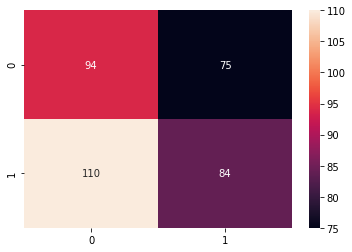

In [80]:
# confusion matrix
cm_lib = confusion_matrix(df_liberal['sentiment'],df_liberal['prediction'])
sns.heatmap(cm_lib,annot=True,fmt='d')
plt.show()

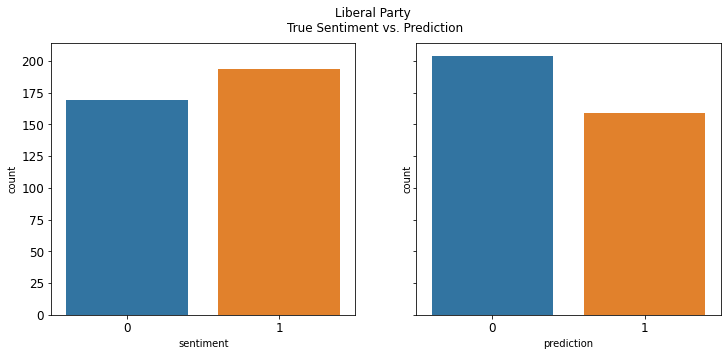

In [81]:
# True sentiment vs prediction for liberal party
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
fig.suptitle('Liberal Party \nTrue Sentiment vs. Prediction', fontsize=12)

sns.countplot(x='sentiment', data=df_liberal,ax=ax1).tick_params(labelsize=12)
sns.countplot(x='prediction', data=df_liberal,ax=ax2).tick_params(labelsize=12)

### Conservative Party

The accuracy for word frequency prediction is 47.45%. Confusion matrix shows that the main prediction error is FP- false positives, which means that we predict these sample to be positive but they are actually negative. The histrogram shows that negative sentiment is underestimate while the positive sentiment is overestimate.

In [73]:
df_conser = df_party[df_party['political_party']=='conservatives']
acc_conser = accuracy_score(df_conser['sentiment'],df_conser['prediction'])
print("Accuracy of Conservative Party: {}%".format(round(acc_conser*100,2)))

Accuracy of Conservative Party: 47.45%


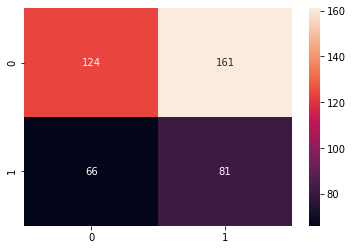

In [74]:
cm_conser = confusion_matrix(df_conser['sentiment'],df_conser['prediction'])
sns.heatmap(cm_conser,annot=True,fmt='d')
plt.show()

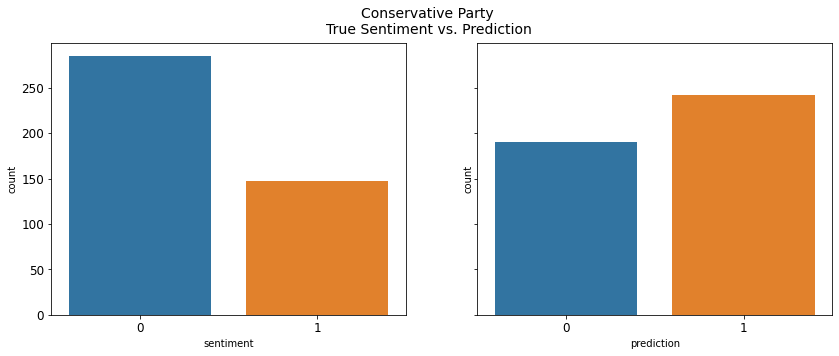

In [75]:
# Prediction VS True for Conservative
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(14,5))
fig.suptitle('Conservative Party \nTrue Sentiment vs. Prediction',fontsize=14)

sns.countplot(x='sentiment', data=df_conser,ax=ax1).tick_params(labelsize=12)
sns.countplot(x='prediction', data=df_conser,ax=ax2).tick_params(labelsize=12)

### New Democratic Party

The accuracy for word frequency prediction is 31.09%. Confusion matrix shows that the main prediction error is FN- false negatives, which means that we predict these sample to be negatives but they are actually positive. The histrogram shows that negative sentiment is overestimate while the positive sentiment is underestimate.

In [76]:
df_ndp = df_party[df_party['political_party']=='new democratic party']
acc_ndp = accuracy_score(df_ndp['sentiment'],df_ndp['prediction'])
print("Accuracy of Conservative Party: {}%".format(round(acc_ndp*100,2)))

Accuracy of Conservative Party: 31.09%


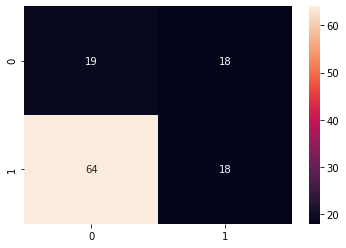

In [77]:
cm_ndp = confusion_matrix(df_ndp['sentiment'],df_ndp['prediction'])
sns.heatmap(cm_ndp,annot=True,fmt='d')
plt.show()

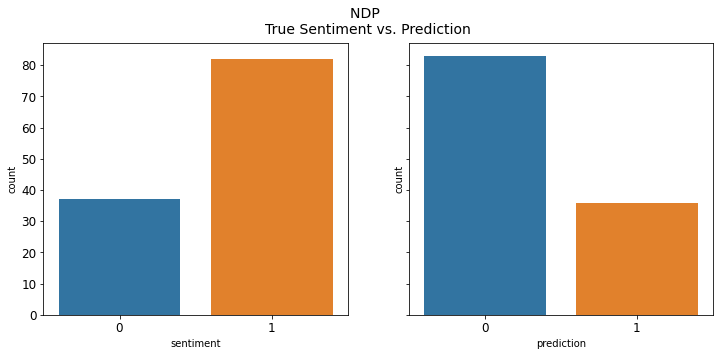

In [78]:
# Prediction VS True for NDP
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
fig.suptitle('NDP \nTrue Sentiment vs. Prediction',fontsize=14)

sns.countplot(x='sentiment', data=df_ndp,ax=ax1).tick_params(labelsize=12)
sns.countplot(x='prediction', data=df_ndp,ax=ax2).tick_params(labelsize=12)

### (d) Multiclass Classifications on Negative Reasons

#### extract the tweets with negative sentiment

In [127]:
#extract negative sentiment
df_reason = df_election[df_election['sentiment'] == 0]
df_reason.index = range(len(df_reason))
df_reason.drop(['sentiment','political_party'],axis=1,inplace=True)
df_reason.head()

,negative_reason,text
0,Women Reproductive right and Racism,instead suggestion agree canadian woman trust ...
1,Economy,brantford go cost 94 billion next 4 year ask j...
2,Economy,canada taxpayer sick tire hard earn donate cor...
3,Others,canadavotes2019 elxn43 cdnpoli fact blastfromt...
4,Others,chooseforward cdnpoli elxn43canada make americ...


In [128]:
df_reason['negative_reason'].unique()

array(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

#### Categorize negative reasons

I categorized all the reasons into four categories. 
 
   * Personal: Scandal, Tell lies, Privilege, Separation
   * Economic: Economy
   * Politics: Women Reproductive right and Racism, Climate Problem, Healthcare, Healthcare and Marijuana
   * Others: others

In [129]:
df_reason['negative_reason'].replace(['Scandal','Tell lies','Privilege','Separation',
                                      'Economy',
                                      'Women Reproductive right and Racism','Climate Problem','Healthcare','Healthcare and Marijuana',
                                      'Others'],
                                      [0,0,0,0,1,2,2,2,2,3],inplace=True)

In [130]:
df_reason.head()

,negative_reason,text
0,2,instead suggestion agree canadian woman trust ...
1,1,brantford go cost 94 billion next 4 year ask j...
2,1,canada taxpayer sick tire hard earn donate cor...
3,3,canadavotes2019 elxn43 cdnpoli fact blastfromt...
4,3,chooseforward cdnpoli elxn43canada make americ...


#### Prepare Dataset by transforming by TFIDF

In [107]:
# Vectorize and fit model
tfidf = TfidfVectorizer(max_features=1000, max_df=0.8)
array_tf_reason = tfidf.fit_transform(df_reason['text'])

In [108]:
# Split into train and test dataset
Xidf_train_r, Xidf_test_r, yidf_train_r, yidf_test_r = train_test_split(array_tf_reason, 
                                                                        df_reason['negative_reason'],test_size=0.3,
                                                                        stratify=df_reason['negative_reason'])

#### Make Predictions and Visualize the Results

In [159]:
#accuracy of TF-IDF model
def get_reason_accuracy(model, X_train, X_test, y_train, y_test):
    
    dic = {'lr':'Logistic Regression',
           'svm':'Support Vector Machine',
           'rf':'Random Forest'}
    
    train_acc, test_acc = [], []
    
    if model == 'lr':
        clf = OneVsRestClassifier(LogisticRegression(C=1, solver='liblinear',multi_class='ovr'))
    elif model == 'svm':
        clf = OneVsRestClassifier(svm.LinearSVC(C=10))
    elif model == 'rf':
        clf = OneVsRestClassifier(RandomForestClassifier(max_depth=200,min_samples_split=5))
    else:
        print('Model doesn\'t exist')

    clf.fit(X_train, y_train)

    # predict using train data
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    
    # predict using test data
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)   
 
    print("Model: ", dic[model])
    print("\nTraining accuracy is: {}%".format(round(train_acc*100,2)))
    print("\nTest accuracy is: {}%".format(round(test_acc*100,2)))
    
    return round(train_acc*100,2), round(test_acc*100,2)

##### Logistic regression model with TF-IDF on Canadian Election data

In [160]:
train_acc_lr, test_acc_lr = get_reason_accuracy('lr',Xidf_train_r, Xidf_test_r, yidf_train_r, yidf_test_r)

Model:  Logistic Regression

Training accuracy is: 100.0%

Test accuracy is: 60.26%


##### Support Vector Machine model with TF-IDF on Canadian Election data

In [161]:
train_acc_nb, test_acc_nb = get_reason_accuracy('svm',Xidf_train_r, Xidf_test_r, yidf_train_r, yidf_test_r)

Model:  Support Vector Machine

Training accuracy is: 100.0%

Test accuracy is: 60.26%


##### Random Forest model with TF-IDF on Canadian Election data

In [162]:
train_acc_rf, test_acc_rf= get_reason_accuracy('rf',Xidf_train_r, Xidf_test_r, yidf_train_r, yidf_test_r)

Model:  Random Forest

Training accuracy is: 99.72%

Test accuracy is: 61.92%


In [163]:
pd.DataFrame([[train_acc_lr,train_acc_nb,train_acc_rf],
              [test_acc_lr,test_acc_nb,test_acc_rf]],index=['Training Accuracy','Test Accuracy'],
              columns=['Logistic Regression','Support Vector Machine','Random Forest'])

,Logistic Regression,Support Vector Machine,Random Forest
Training Accuracy,100.00,100.00,99.72
Test Accuracy,60.26,60.26,61.92


## 5 Discussion

### (a) Sentiment Analysis Discussion

1. By presenting the political parties in histogram, I surprisingly found that the dominating political party is "None". It may be that the keywords are not enough to classify political parties or people are more interested in other parties. Other than "None", liberal party and conservative party are two main portion in tweets, while NDP occupy only a little portion. By presenting the sentiment for generic tweets data in histogram, I found that positive sentiment is about double more than the negative sentiment. Also, by presenting the wordcloud regarding the positive sentiments on liberal party, which is the winner party in 2019 election, I found that the most popular word is "chooseforward", "liberal", and "trudeau". However, "elxn43" and "cdnpoli" are not appropriate and cannot provide any useful information, which should be removed during the following prediction.


2. In the visualization of three parties' sentiment distribution, the negative sentiment and positive sentiment are fairly distributed for the liberal party, which means that the public views for liberal party is without bias toward any end; the number of negative sentiment is about double more than the number of positive sentiment for the conservative party, which means that conservative party is not welcomed for the majority; on the contrary, the number of positive sentiment is more than double than the number of negative sentiment for the NDP, which means that NDP receives many supporters. 


3. After training seven models on the training data from generic tweets and applying the model to the test data to obtain an accuracy value, the logistic regression model with hyperparameter C=1 turns out to the best model with the highest accuracy. However, it does not perform well when it comes to sentiment prediction of Canadian election data. The accuracy for liberal, conservative, and NDP party is 49.04%, 47.45%, and 31.09% respectively. For liberal party and NDP, the sentiment predictions exhibit false negatives error, which means that negative sentiment is overestimate while the positive sentiment is underestimate. On the contrary, for conservative party, the sentiment predictions exhibit false positive error, which means that negative sentiment is underestimate while the positive sentiment is overestimate. The potential reason for the prediction error may be that there are too many negative sentiments for conservative party and too many positive sentiments for NDP. Thus, the negative sentiments are predicted as positive for conservative party while the positive sentiments are predicted as negative for NDP.


4. Logistic regression, support vector machine, and random forest, as the three best models for sentiment predictions on generic tweets, achieve nearly 100% accuracy in training data but achieve only about 60% in test data for Canadian election dataset. The potential reason for prediction error may be that there is insufficient data for modeling. 

### (b) Reasons for prediction error

The Training accuracy for logistic regression and support vector machine model reaches 100% but test accuracy is 60%. The reason may be insufficient dataset and different distribution of training data and testing data. An recommendation is to apply some feature selection or feature reduction (like PCA) approaches to tackle the overfitting problem. Also, elaborate the "Other" type of negative reason. Third, drop the irrelevant words that may negatively impact the performance of the model on new data, such as "elxn43" and "cdnpoli" as shown in question 2.

##### Test dataset vs Prediction

As shown from the test dataset vs prediction, it is obvious that category 0 (personal reasons) and category 3 (other reasons) dominate the prediction. Category 1 (economic reasons) and category 2 (politics reasons) may be predicted as category 0 or 3, because personal reasons and other reasons make up a large portion in negative reasons. Say number 168 and 218 and 143, which are category 1 and 2, they are predicted as category 0 and 3. It is because that the category 0 and 3 made up of 85% of the whole dataset. Thus, other type of reason should be elaborate more while personal reason may be seperate into several categories. 

In [186]:
clf = OneVsRestClassifier(LogisticRegression(C=1, solver='liblinear',multi_class='ovr'))
clf.fit(Xidf_train_r, yidf_train_r)
pred_lr = clf.predict(Xidf_test_r)
test_acc = accuracy_score(yidf_test_r, pred_lr)
pd.set_option('display.max_columns',None)
pd.DataFrame([pred_lr,yidf_test_r],index=['Prediction','True'],columns=yidf_test_r.index)

,168,708,451,754,777,90,189,458,387,574,218,819,242,15,13,100,208,194,112,413,605,322,921,104,594,180,626,0,532,162,19,483,254,757,140,606,602,644,473,909,1004,497,971,780,192,871,296,499,143,288,362,826,164,997,553,421,841,435,811,457,258,427,91,251,356,931,807,961,21,941,430,697,794,341,59,117,239,521,358,193,113,490,471,556,563,679,910,97,102,448,157,213,235,873,184,967,80,216,984,236,542,846,661,94,407,412,376,887,488,793,611,982,121,551,166,191,560,575,782,668,315,6,219,735,689,614,134,959,742,514,248,710,633,933,481,916,667,700,144,320,392,608,788,683,374,475,229,655,347,695,444,911,857,899,649,884,781,972,533,724,565,897,510,974,42,321,762,935,185,64,276,628,987,993,828,647,283,328,805,329,187,773,973,95,741,779,631,115,270,960,294,656,616,364,35,577,648,681,360,419,72,440,478,334,836,151,17,523,728,460,671,297,613,670,57,650,727,308,635,672,716,791,22,1001,892,927,544,45,761,953,678,692,699,711,175,950,731,443,247,702,856,548,415,920,954,862,747,323,998,146,231,621,255,569,531,77,528,18,970,343,167,150,74,590,977,706,835,876,763,232,243,737,641,177,119,331,359,44,746,583,785,303,262,67,850,745,250,944,582,914,378,937,915,406,217,253,401,203,617,206,371,567
Prediction,0,3,0,0,3,3,0,0,3,3,3,0,0,0,3,0,3,0,3,3,3,3,3,0,0,3,3,2,0,2,0,0,2,3,3,3,0,0,0,3,0,3,0,3,3,0,0,0,0,3,3,3,0,0,3,0,0,0,0,3,0,3,0,3,0,2,3,0,0,3,3,3,2,0,0,0,0,0,3,3,2,0,3,2,0,3,3,3,0,3,2,3,3,0,3,0,3,3,3,0,3,3,3,0,3,3,0,3,0,0,0,0,0,0,0,0,3,0,0,0,3,3,0,0,0,3,0,3,0,0,0,3,0,0,3,0,0,3,3,3,3,2,3,3,0,3,0,0,3,3,3,3,0,0,3,3,3,0,3,0,0,3,0,0,0,0,3,2,3,3,3,3,3,0,0,0,3,0,0,3,3,3,0,2,0,0,0,3,0,0,3,0,0,3,3,0,0,0,3,0,3,0,3,3,0,0,1,3,0,3,0,2,3,0,0,3,0,3,0,0,0,0,0,3,3,0,0,3,3,3,0,0,3,0,3,3,3,3,0,3,0,0,2,3,0,3,0,3,2,3,0,0,3,3,0,0,2,0,3,0,0,0,3,3,3,3,0,3,3,3,0,0,3,2,3,0,0,0,3,0,3,0,0,0,0,2,0,3,0,0,0,3,3,3,0,0,2,0,3,0,3,3
True,2,0,0,0,0,3,0,3,3,3,2,0,0,0,3,0,0,3,2,3,3,3,0,0,0,0,0,2,0,0,3,0,2,0,0,3,0,3,0,3,0,0,0,0,3,0,0,0,1,0,2,0,0,2,3,0,3,0,1,3,0,0,3,3,3,2,2,3,0,3,3,3,2,0,0,0,0,0,3,3,2,3,0,2,0,3,3,3,3,3,2,0,3,0,0,0,1,3,0,0,3,0,0,0,0,2,0,2,0,0,3,0,0,1,3,3,1,0,3,3,3,3,3,3,0,3,0,3,0,0,3,3,0,0,3,0,0,0,0,3,0,3,3,0,0,2,0,0,3,3,3,3,0,0,3,0,3,1,0,0,2,1,1,0,0,0,2,0,3,2,0,0,0,0,0,3,1,0,3,3,3,0,2,2,0,3,0,0,0,0,3,1,0,3,0,0,0,0,3,0,3,0,3,0,0,0,0,3,1,2,0,2,3,0,0,0,3,3,0,0,3,3,1,3,3,3,3,0,3,3,0,3,0,0,3,3,0,3,0,0,3,0,2,3,0,0,0,0,3,1,0,0,1,3,2,3,2,3,3,3,3,0,0,3,3,3,3,3,0,3,2,0,0,3,3,0,0,0,0,0,3,3,3,0,3,2,0,3,0,0,0,3,0,3,0,0,2,0,0,0,0,1


In [195]:
#personal reasons
len(df_reason[df_reason['negative_reason']==0])

496

In [196]:
#economic reasons
len(df_reason[df_reason['negative_reason']==1])

51

In [197]:
len(df_reason[df_reason['negative_reason']==2])

95

In [198]:
len(df_reason[df_reason['negative_reason']==3])

364

In [202]:
(496+364)/(496+364+51+95)

0.8548707753479126